# AnonNet 

An approach to de-identifying faces for exchange of protected patient information (PHI) among relevant stakeholders. 

### Import Libraries and Setup Notebook

In [1]:
%reload_ext autoreload
%autoreload 2

In [14]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *

1. download all parts of helen data - combine all into train folder (should hve 2330)
2. rename annotation files with image (1.txt -> 100032540_1_anno.txt)

### Download Helen Facepoint Data

Download all "Helen" facial keypoint data from the [following link](http://www.ifp.illinois.edu/~vuongle2/helen/). Make sure to get part 1 through 5, and store in a single "train" folder. Also download the annotations and unzip to an "annotation" folder. Your directory structure should look like the following. Ignore the "models" folder - it will be created during training.   

In [237]:
path = Path('/home/sudosharma/projects/data/helen/')
path.ls()

[PosixPath('/home/sudosharma/projects/data/helen/annotation'),
 PosixPath('/home/sudosharma/projects/data/helen/models'),
 PosixPath('/home/sudosharma/projects/data/helen/train')]

### Rename Annotation Files

In [4]:
def rename_anno_files(anno_path):
    """Rename annotation files with image name (1.txt -> 100032540_1_anno.txt)"""
    for anno in anno_path.ls():
        if anno.stem.find('anno') > 0:  # ignore if already renamed
            return
        with open(anno) as f:
            fname = f.readline().strip()
        anno.rename(anno.parent / f'{fname}_anno.txt')
    return

In [5]:
rename_anno_files(path/'annotation')

### Prep Data for Model

In [245]:
def _get_size(xs,i):
    """Get size of image to scale keypoints."""
    size = xs.sizes.get(i,None)
    if size is None:
        # Image hasn't been accessed yet, so we don't know its size
        _ = xs[i]
        size = xs.sizes[i]
    return size

class CustomPointsProcessor(PreProcessor):
    """`PreProcessor` that stores the number of targets for point regression."""
    def __init__(self, ds:ItemList): self.c = 136
    def process(self, ds:ItemList):  ds.c = self.c

class CustomPointsLabelList(ItemList):
    """`ItemList` for points."""
    _processor = CustomPointsProcessor

    def __post_init__(self): self.loss_func = MSELossFlat()

    def get(self, i):
        o = super().get(i)
        return ImagePoints(FlowField(_get_size(self.x,i), o), scale=True)

    def analyze_pred(self, pred, thresh:float=0.5): return pred.view(-1,2)
    def reconstruct(self, t, x): return ImagePoints(FlowField(x.size, t), scale=False)
    
def custom_collate(batch:ItemsList)->Tensor:
    """Convert `batch` items to tensor data, for batch training."""
    batch_data = to_data(batch)
    if isinstance(batch_data[0][1], int): return data_collate(batch_data)
    pad_batch = []
    for img, anno in batch_data:
        if anno.shape[0] < 136:  # pad annotation if clipped during data augmentation or not available
            anno = F.pad(anno, (0, 0, 136-anno.shape[0], 0))
        pad_batch.append([img, anno])
    return torch.utils.data.dataloader.default_collate(pad_batch)

In [242]:
def get_annos(o):
    """Get annotations from files for corresponding image."""
    anno = path/'annotation'/f'{o.stem}_anno.txt'
    points = []
    with open(anno) as f:
        for line in f:
            points.append([float(coord) for coord in line.strip().split(',')][::-1])
    points = torch.Tensor(points[59:])  # ignore jawline and nose keypoints
    return points

def get_data(sz=128, bs=8, path=path):
    """Create batches of data from folders, apply size transformations, and normalize to imagenet stats."""
    return (PointsItemList.from_folder(path)
            .split_by_rand_pct(0.2)
            .label_from_func(get_annos, label_cls=CustomPointsLabelList)
            .transform(tfm_y=True, size=sz)
            .databunch(bs=bs, collate_fn=custom_collate)
            .normalize(imagenet_stats))

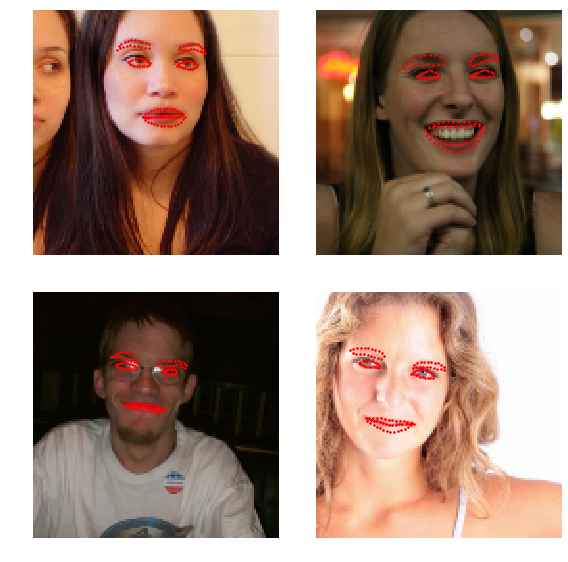

In [243]:
data = get_data()
data.show_batch(2)

### AnonNet Training

In [219]:
class AnonNet(nn.Module):
    """A network to train facial keypoint detection for de-identification. Uses pretrained ResNet34 as base."""
    def __init__(self, backbone, pretrained=True):
        super().__init__()
        self.base = create_body(backbone, pretrained=pretrained)
        self.layers = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=(1, 1)),
            Flatten(),
            nn.Linear(512, 272),
            nn.Tanh())
    
    def forward(self, x):
        return self.layers(self.base(x)).view(-1, 136, 2)

In [247]:
backbone = models.resnet34
model = AnonNet(backbone)
learn = Learner(data, 
                model, 
                opt_func=partial(optim.SGD, momentum=0.95), 
                loss_func=F.l1_loss)
learn.init(nn.init.kaiming_normal_)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


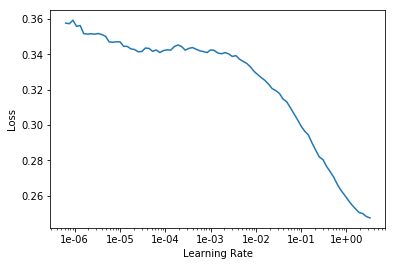

In [221]:
learn.lr_find()  # learning rate finder
learn.recorder.plot()

### Run 1 
Terminated after 50 epochs because losses plateaued.

In [222]:
callbacks = [
    SaveModelCallback(learn, name='anonnet'), 
    TerminateOnNaNCallback(), 
    GradientClipping(learn, clip=0.1),
    ReduceLROnPlateauCallback(learn, patience=50, min_delta=0.001)]
learn.callbacks.extend(callbacks)

In [223]:
learn.fit(100, 1e-1)

epoch,train_loss,valid_loss,time
0,0.148829,0.139480,00:39
1,0.136929,0.137507,00:39
2,0.137882,0.144139,00:39
3,0.134663,0.140745,00:39
4,0.131412,0.130974,00:39
5,0.128433,0.128063,00:39
6,0.113926,0.109965,00:39
7,0.105745,0.103843,00:39
8,0.101496,0.104200,00:39
9,0.098683,0.100139,00:40


Better model found at epoch 0 with val_loss value: 0.13947953283786774.
Better model found at epoch 1 with val_loss value: 0.13750654458999634.
Better model found at epoch 4 with val_loss value: 0.13097433745861053.
Better model found at epoch 5 with val_loss value: 0.12806282937526703.
Better model found at epoch 6 with val_loss value: 0.10996536165475845.
Better model found at epoch 7 with val_loss value: 0.10384280979633331.
Better model found at epoch 9 with val_loss value: 0.10013880580663681.
Better model found at epoch 11 with val_loss value: 0.09990663826465607.
Better model found at epoch 12 with val_loss value: 0.09426377713680267.
Better model found at epoch 15 with val_loss value: 0.09309778362512589.
Better model found at epoch 19 with val_loss value: 0.09254355728626251.
Better model found at epoch 20 with val_loss value: 0.09160365164279938.
Better model found at epoch 21 with val_loss value: 0.09035477042198181.
Better model found at epoch 23 with val_loss value: 0.0887

KeyboardInterrupt: 

### Run 2
Lowered learning rate 10x and terminated after 40 epochs because losses plateaued. 

In [226]:
callbacks = [
    SaveModelCallback(learn, name='anonnet_1'), 
    TerminateOnNaNCallback(), 
    GradientClipping(learn, clip=0.1),
    ReduceLROnPlateauCallback(learn, patience=50, min_delta=0.001)]
learn.callbacks.extend(callbacks)

In [227]:
learn.fit(100, 1e-2)

epoch,train_loss,valid_loss,time
0,0.078905,0.079622,00:39
1,0.078613,0.078839,00:39
2,0.077293,0.078762,00:39
3,0.076978,0.078808,00:39
4,0.078687,0.078690,00:39
5,0.077174,0.078428,00:39
6,0.076363,0.078690,00:39
7,0.077462,0.078611,00:39
8,0.077857,0.078523,00:39
9,0.075711,0.078553,00:39


Better model found at epoch 0 with val_loss value: 0.07962234318256378.
Better model found at epoch 0 with val_loss value: 0.07962234318256378.
Better model found at epoch 1 with val_loss value: 0.07883895933628082.
Better model found at epoch 1 with val_loss value: 0.07883895933628082.
Better model found at epoch 2 with val_loss value: 0.07876154035329819.
Better model found at epoch 2 with val_loss value: 0.07876154035329819.
Better model found at epoch 4 with val_loss value: 0.07868964970111847.
Better model found at epoch 4 with val_loss value: 0.07868964970111847.
Better model found at epoch 5 with val_loss value: 0.07842803001403809.
Better model found at epoch 5 with val_loss value: 0.07842803001403809.
Better model found at epoch 11 with val_loss value: 0.07826175540685654.
Better model found at epoch 11 with val_loss value: 0.07826175540685654.
Better model found at epoch 14 with val_loss value: 0.07824693620204926.
Better model found at epoch 14 with val_loss value: 0.0782469

KeyboardInterrupt: 

### Run 3
Lowered learning rate 10x and terminated after 20 epochs because losses plateaued. 

In [229]:
callbacks = [
    SaveModelCallback(learn, name='anonnet_2'), 
    TerminateOnNaNCallback(), 
    GradientClipping(learn, clip=0.1),
    ReduceLROnPlateauCallback(learn, patience=50, min_delta=0.001)]
learn.callbacks.extend(callbacks)

In [230]:
learn.fit(100, 1e-3)

epoch,train_loss,valid_loss,time
0,0.076372,0.077790,00:39
1,0.078207,0.077698,00:39
2,0.074480,0.077609,00:39
3,0.078506,0.077630,00:39
4,0.073737,0.077625,00:39
5,0.072694,0.077666,00:39
6,0.074852,0.077647,00:39
7,0.075410,0.077606,00:39
8,0.077170,0.077665,00:39
9,0.072584,0.077654,00:39


Better model found at epoch 0 with val_loss value: 0.0777900218963623.
Better model found at epoch 0 with val_loss value: 0.0777900218963623.
Better model found at epoch 0 with val_loss value: 0.0777900218963623.
Better model found at epoch 1 with val_loss value: 0.0776977613568306.
Better model found at epoch 1 with val_loss value: 0.0776977613568306.
Better model found at epoch 1 with val_loss value: 0.0776977613568306.
Better model found at epoch 2 with val_loss value: 0.07760924100875854.
Better model found at epoch 2 with val_loss value: 0.07760924100875854.
Better model found at epoch 2 with val_loss value: 0.07760924100875854.
Better model found at epoch 7 with val_loss value: 0.0776057168841362.
Better model found at epoch 7 with val_loss value: 0.0776057168841362.
Better model found at epoch 7 with val_loss value: 0.0776057168841362.
Better model found at epoch 11 with val_loss value: 0.07760307192802429.
Better model found at epoch 11 with val_loss value: 0.07760307192802429.

KeyboardInterrupt: 

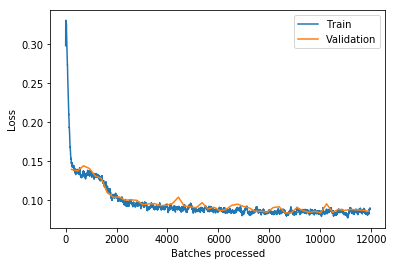

In [224]:
learn.recorder.plot_losses()  # loss for Run 1

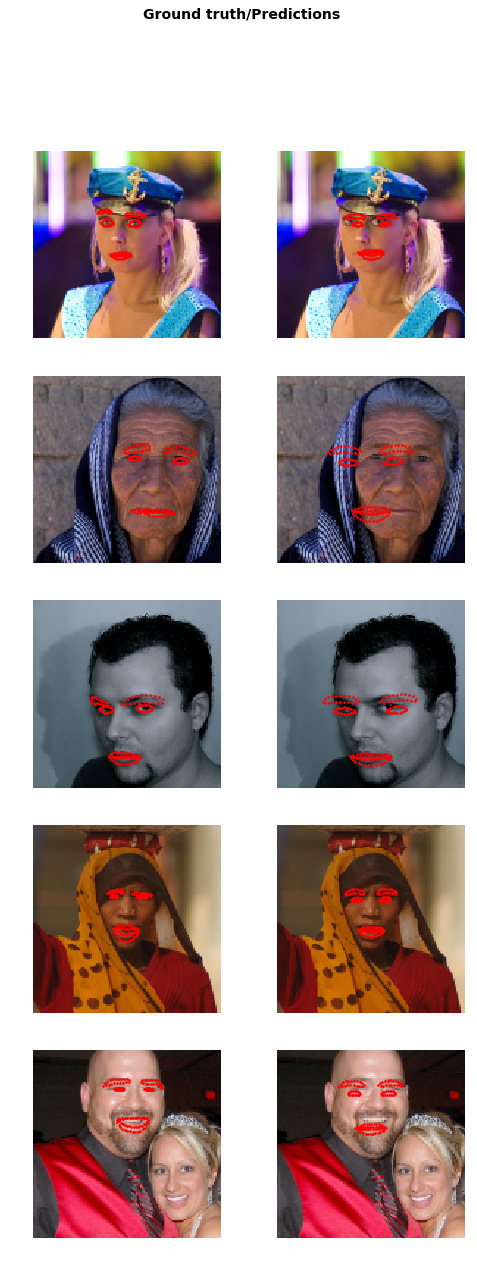

In [236]:
learn.show_results()

### Analysis
AnonNet has learned to localize faces, eyes, eyebrows, and mouths, but has difficulty when face is translated. Potential for improvement with a pretrained network trained on faces. Also could improve using feature pyramid network or other architecture with skip connections. 

### Blur Faces Using AnonNet Predictions

In [291]:
img = learn.data.train_ds[0][0]
pred = learn.model.cpu()(img.data.unsqueeze(0))

In [293]:
pred

tensor([[[ 0.1060, -0.1494],
         [ 0.0954, -0.1299],
         [ 0.0876, -0.1076],
         [ 0.0814, -0.0854],
         [ 0.0768, -0.0617],
         [ 0.0748, -0.0375],
         [ 0.0748, -0.0146],
         [ 0.0740,  0.0076],
         [ 0.0732,  0.0316],
         [ 0.0737,  0.0548],
         [ 0.0768,  0.0786],
         [ 0.0818,  0.1012],
         [ 0.0907,  0.1219],
         [ 0.1054,  0.1338],
         [ 0.1239,  0.1318],
         [ 0.1403,  0.1166],
         [ 0.1550,  0.0993],
         [ 0.1666,  0.0784],
         [ 0.1758,  0.0568],
         [ 0.1809,  0.0340],
         [ 0.1839,  0.0099],
         [ 0.1842, -0.0131],
         [ 0.1815, -0.0364],
         [ 0.1764, -0.0595],
         [ 0.1665, -0.0805],
         [ 0.1534, -0.0995],
         [ 0.1393, -0.1185],
         [ 0.1238, -0.1360],
         [ 0.1085, -0.1317],
         [ 0.1064, -0.1145],
         [ 0.1055, -0.0953],
         [ 0.1055, -0.0766],
         [ 0.1050, -0.0577],
         [ 0.1055, -0.0383],
         [ 0.1

In [295]:
img.shape

torch.Size([3, 128, 128])

In [296]:
pred * 128

tensor([[[ 13.5725, -19.1202],
         [ 12.2074, -16.6274],
         [ 11.2068, -13.7674],
         [ 10.4253, -10.9362],
         [  9.8342,  -7.8951],
         [  9.5771,  -4.8012],
         [  9.5733,  -1.8648],
         [  9.4756,   0.9731],
         [  9.3729,   4.0499],
         [  9.4378,   7.0170],
         [  9.8272,  10.0572],
         [ 10.4691,  12.9518],
         [ 11.6131,  15.6057],
         [ 13.4922,  17.1309],
         [ 15.8589,  16.8697],
         [ 17.9590,  14.9294],
         [ 19.8455,  12.7058],
         [ 21.3196,  10.0314],
         [ 22.5068,   7.2679],
         [ 23.1581,   4.3558],
         [ 23.5420,   1.2656],
         [ 23.5713,  -1.6813],
         [ 23.2266,  -4.6584],
         [ 22.5735,  -7.6124],
         [ 21.3073, -10.3032],
         [ 19.6322, -12.7340],
         [ 17.8357, -15.1707],
         [ 15.8424, -17.4089],
         [ 13.8872, -16.8630],
         [ 13.6179, -14.6563],
         [ 13.5068, -12.1938],
         [ 13.5063,  -9.8037],
        

In [274]:
img = learn.data.train_ds[1][0]
img, points, _ = learn.predict(img)

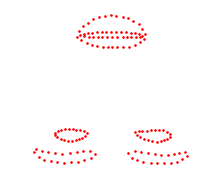

In [273]:
img.show()

TypeError: scatter() got multiple values for argument 'y'

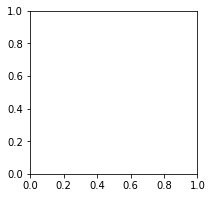

In [275]:

img = ImagePoints(FlowField(img.size, points))
img.show(y=points)